# Downstream Analysis - Python

Now for the fun bit, wrangling the data and plotting our results! Below, we do this using pandas, matplotlib and statsmodels, and some convenience functions from `py_clone_detective.clone_analysis`.

First, we read in results previously generated by py_clone_detector:

In [ ]:
import pandas as pd

df = pd.read_csv('data/example_results.csv')

df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,centroid-0,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,preEC_pos,ISCorEB_pos
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,44.054696,89.552116,0.440881,73.280625,False,2196457.0,True,False,False,False
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,44.054696,89.552116,0.440881,73.280625,False,52757.0,True,False,False,False
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,44.054696,89.552116,0.440881,73.280625,False,2262648.0,True,False,False,False
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,44.054696,89.552116,0.440881,73.280625,False,67331.0,True,False,False,False
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,53.590038,486.798467,0.465227,98.690625,False,4113516.0,True,False,False,False


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
count_df = df.query('int_img_ch == "C1"').filter(regex=r"clone$|pos$|int_img")

Next, we groupby clones per image and sum to get the number of cells of each type per clone.

In [ ]:
count_df = count_df.groupby(["int_img", "GFP_clone"]).sum().reset_index()
count_df.head()

,int_img,GFP_clone,GFP_clonepos,EC_pos,EE_pos,preEC_pos,ISCorEB_pos
0,a1g01p1,0,0,70,2,4,99
1,a1g01p1,1,14,9,0,0,5
2,a1g01p1,2,1,0,0,0,1
3,a1g01p1,3,4,1,0,0,3
4,a1g01p1,4,34,12,0,0,22


We can add a sum all cell types per clone to get an additional 'total' column:

In [ ]:
import re
# drop the unneeded "GFP column"
count_df = count_df.drop(columns="GFP_clonepos")
# simplify column names
count_df.columns = [re.sub("_pos", "", col) for col in count_df.columns]
# calculate the total cell
count_df = count_df.eval("total = EC + preEC + EE + ISCorEB")

Since where "GFP_clone" == 0, we can add an additional column stating whether a "GFP_clone" is inside a clone (*IC*) or outside a clone (*OC*):

In [ ]:
import numpy as np

count_df["clone_status"] = np.where(count_df["GFP_clone"] == 0, "OC", "IC")

Finally, the images are named 'a1' if from a wild-type (*ctrl*) animal and 'a2' if from a mutant (*mut*) animal. We can therefore add a 'genotype' column:

In [ ]:
count_df["genotype"] = np.where(count_df["int_img"].str.match(r"a1"), "ctrl", "mut")

We can groupby this genotype column and generate a stacked bar plot displaying cell numbers and types per clone. Here, we only interested in plotting cells inside clones, and so we first query on 'clone_status':

In [ ]:
count_df_inside = count_df.query('clone_status == "IC"')

inside_clone_mean = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE"]]
    .groupby("genotype")
    .mean()
)

inside_clone_sem = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE"]]
    .groupby("genotype")
    .sem()
)

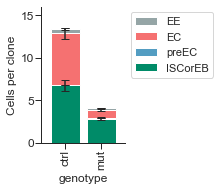

In [ ]:
import py_clone_detective.clone_analysis as ca

ca.create_stack_bar_plot(
    inside_clone_mean,
    inside_clone_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
    y_axis_limit=16,
    y_label="Cells per clone",
)

From this plot we can see that 'mutant' clones are on average bigger than 'ctrl' clones. This suggests that the mutation in our gene of interest may affect **cell proliferation**. Let do a t-test using the statsmodels library to see if this difference is significant:

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
lm = ols("total ~ genotype", data=count_df_inside).fit()
lm.t_test_pairwise("genotype").result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
mut-ctrl,-9.296581,1.257855,-7.390821,7.756635e-13,-11.76894,-6.824223,7.757128e-13,True


Yes, the total number of cell per clone is significantly different in "ctrl" vs "mutant" animals. 

## Cell Differentiation - percentage cell type inside and outside clones

Next, let's investigate whether the types of cells inside and outside clones are different in ctrl and mutant animals. This information will help us determine whether our gene of interest affects **cell differentiation**.

First, since we already know that 'mutant' clones possess fewer cells than 'ctrl' clones, it is helpful to summarise cell types as a percentage.

In [ ]:
percentage_df = count_df.eval(
    """EC = EC / total * 100 
    EE = EE / total * 100 
    preEC = preEC / total * 100 
    ISCorEB = ISCorEB / total * 100"""
)

Next, we plot a stacked barplot as before. However, this time we plot percentage cell types:

In [ ]:
percentage_df_mean = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE"]]
    .groupby(["clone_status", "genotype"])
    .mean()
)

percentage_df_sem = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE"]]
    .groupby(["clone_status", "genotype"])
    .sem()
)

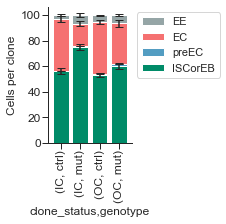

In [ ]:
ca.create_stack_bar_plot(
    percentage_df_mean,
    percentage_df_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
    y_label="Cells per clone",
)

This plot suggests there might be a difference in percentage cell-types of mutant clones vs ctrl. Let's check if these differences are statistically significant.

To do this, we reshape our percentage data into a tidy format:

In [ ]:
tidy_percentage_df = pd.melt(
    percentage_df,
    id_vars=["genotype", "clone_status"],
    value_vars=["EC", "preEC", "EE", "ISCorEB"],
    var_name="cell_type",
    value_name="perc_cell_num",
)
tidy_percentage_df.head()

,genotype,clone_status,cell_type,perc_cell_num
0,ctrl,OC,EC,40.000000
1,ctrl,IC,EC,64.285714
2,ctrl,IC,EC,0.000000
3,ctrl,IC,EC,25.000000
4,ctrl,IC,EC,35.294118


We then create a composite column that contains genotype (g), clone_status (cs) and cell_type (ct) information.

In [ ]:
tidy_percentage_df["comp_g_cs_ct"] = (
    tidy_percentage_df["genotype"]
    + "_"
    + tidy_percentage_df["clone_status"]
    + "_"
    + tidy_percentage_df["cell_type"]
)
tidy_percentage_df.head()

tidy_percentage_df["comp_g_cs_ct"] = tidy_percentage_df["comp_g_cs_ct"].astype(
    "category"
)

Using statsmodels and patsy, we set up a ContrastMatrix for our desired comparisons.

Our first set of contrasts compares the percentage of each cell type <u>inside mutant vs ctrl</u> clones:

In [ ]:
contrasts = [
    "mut_IC_EC-ctrl_IC_EC",
    "mut_IC_EE-ctrl_IC_EE",
    "mut_IC_preEC-ctrl_IC_preEC",
    "mut_IC_ISCorEB-ctrl_IC_ISCorEB",
]

We would also like to compare the percentage of each cell type <u>outside mutant vs inside mutant</u> clones.

In [ ]:
contrasts = contrasts + [
    "mut_OC_EC-mut_IC_EC",
    "mut_OC_EE-mut_IC_EE",
    "mut_OC_preEC-mut_IC_preEC",
    "mut_OC_ISCorEB-mut_IC_ISCorEB",
]

Below is a helper function to construct the values of contrast matrix:

In [ ]:
def create_contrast_matrix(desired_contrasts, df_column):
    l = list()
    levels = pd.Series(df_column.cat.categories.values)
    for contrast in desired_contrasts:
        group_A, group_B = contrast.split("-")
        l.append(levels.replace({group_A: -1, group_B: 1, ".": 0}, regex=True))
    return np.stack(l, axis=1)

We can now setup a custom contrast matrix using patsy:

In [ ]:
matrix = create_contrast_matrix(contrasts, tidy_percentage_df["comp_g_cs_ct"])

from patsy.contrasts import ContrastMatrix

c_matrix = ContrastMatrix(matrix=matrix, column_suffixes=contrasts)
c_matrix

ContrastMatrix(array([[ 1,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  1,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  1,  0,  0,  0,  0],
                      [ 0,  0,  1,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0],
                      [-1,  0,  0,  0,  1,  0,  0,  0],
                      [ 0, -1,  0,  0,  0,  1,  0,  0],
                      [ 0,  0,  0, -1,  0,  0,  0,  1],
                      [ 0,  0, -1,  0,  0,  0,  1,  0],
                      [ 0,  0,  0,  0, -1,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, -1,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, -1],
                      [ 0,  0,  0,  0,  0,  0, -1,  0]]),
               ['mut_IC_EC-ctrl_IC_EC',
                'mut_IC_EE-ctrl_IC_EE',
                'mut_I

Finally, we construct a 'ordinary least squares' (ols) model using statsmodels and test our desired contrasts:

In [ ]:
lm = ols("perc_cell_num ~ C(comp_g_cs_ct, c_matrix) -1", data=tidy_percentage_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          perc_cell_num   R-squared (uncentered):                   0.372
Model:                            OLS   Adj. R-squared (uncentered):              0.370
Method:                 Least Squares   F-statistic:                              146.5
Date:                Tue, 24 Aug 2021   Prob (F-statistic):                   1.21e-193
Time:                        17:16:53   Log-Likelihood:                         -9810.5
No. Observations:                1984   AIC:                                  1.964e+04
Df Residuals:                    1976   BIC:                                  1.968e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
C(comp_g_cs_ct, c_matrix)mut_IC_EC-ctrl_IC_EC              28.8560      2.276     12.680      0.000      24.393      33.319
C(comp_g_cs_ct, c_matrix)mut_IC_EE-ctrl_IC_EE               0.9954      2.276      0.437      0.662      -3.467       5.458
C(comp_g_cs_ct, c_matrix)mut_IC_preEC-ctrl_IC_preEC         0.0658      2.276      0.029      0.977      -4.397       4.529
C(comp_g_cs_ct, c_matrix)mut_IC_ISCorEB-ctrl_IC_ISCorEB    31.3352      2.276     13.770      0.000      26.872      35.798
C(comp_g_cs_ct, c_matrix)mut_OC_EC-mut_IC_EC               36.8841      2.885     12.787      0.000      31.227      42.541
C(comp_g_cs_ct, c_matrix)mut_OC_EE-mut_IC_EE                5.9188      2.885      2.052      0.040       0.262      11.576
C(comp_g_cs_ct, c_matrix)mut_OC_preEC-mut_IC_preEC          0.3197      2.885      0.111      0.912      -5.337       5.977
C(comp_g_cs_ct, c_matrix)mut_OC_ISCorEB-mut_IC_ISCorEB     85.8402      2.885     29.759      0.000      80.183      91.497
==============================================================================
Omnibus:                      694.167   Durbin-Watson:                   1.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2600.889
Skew:                           1.700   Prob(JB):                         0.00
Kurtosis:                       7.461   Cond. No.                         2.44
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Alternative approach:**  
If we did not have specific contrast we were interested, we could perform FDR adjusted pairwise t-tests for all possible comparisons:

In [ ]:
lm = ols("perc_cell_num ~ comp_g_cs_ct", tidy_percentage_df).fit()
stat_df = lm.t_test_pairwise("comp_g_cs_ct", method="fdr_bh").result_frame.reset_index()
# clean up column names
stat_df = stat_df.rename(
    columns={"index": "comparisons", "pvalue-fdr_bh": "pvalue_fdr_bh", "reject-fdr_bh":"reject_fdr_bh"}
)

stat_df.head()

,comparisons,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue_fdr_bh,reject_fdr_bh
0,ctrl_IC_EE-ctrl_IC_EC,-37.393937,2.292158,-16.313858,3.243038e-56,-41.889249,-32.898626,2.432278e-55,True
1,ctrl_IC_ISCorEB-ctrl_IC_EC,15.521449,2.292158,6.771545,1.676488e-11,11.026138,20.016760,3.352976e-11,True
2,ctrl_IC_preEC-ctrl_IC_EC,-40.072714,2.292158,-17.482529,9.907919e-64,-44.568025,-35.577403,9.907919e-63,True
3,ctrl_OC_EC-ctrl_IC_EC,0.106221,4.206373,0.025252,9.798562e-01,-8.143192,8.355634,9.798562e-01,False
4,ctrl_OC_EE-ctrl_IC_EC,-35.184974,4.206373,-8.364682,1.125995e-16,-43.434388,-26.935561,2.702389e-16,True


Filtering to look at our favourite comparisons:

In [ ]:
stat_df.query("comparisons in @contrasts")

,comparisons,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue_fdr_bh,reject_fdr_bh
7,mut_IC_EC-ctrl_IC_EC,-22.766303,2.194574,-10.373906,1.384211e-24,-27.070236,-18.462370,4.885449e-24,True
22,mut_IC_EE-ctrl_IC_EE,3.578422,2.194574,1.630577,1.031396e-01,-0.725510,7.882355,1.375194e-01,False
36,mut_IC_ISCorEB-ctrl_IC_ISCorEB,19.057679,2.194574,8.683999,7.874749e-18,14.753746,23.361612,2.010574e-17,True
49,mut_IC_preEC-ctrl_IC_preEC,0.130202,2.194574,0.059329,9.526962e-01,-4.173731,4.434134,9.688436e-01,False
95,mut_OC_EC-mut_IC_EC,14.120186,4.208599,3.355080,8.084895e-04,5.866408,22.373965,1.183155e-03,True
102,mut_OC_EE-mut_IC_EE,-0.198641,4.208599,-0.047199,9.623595e-01,-8.452420,8.055138,9.704466e-01,False
108,mut_OC_ISCorEB-mut_IC_ISCorEB,-15.113289,4.208599,-3.591050,3.374235e-04,-23.367068,-6.859510,5.061352e-04,True
113,mut_OC_preEC-mut_IC_preEC,1.191744,4.208599,0.283169,7.770773e-01,-7.062035,9.445522,8.252148e-01,False


## Number of neighbours

In [ ]:
nc_df = df.query('int_img_ch == "C0"')
nc_df.set_index(['int_img', 'label', "GFP_clone"], inplace=True)
nc_df = nc_df.filter(regex=r'pos|tot_nc')
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'GFP'))
nc_df['cell_type'] = nc_df.filter(regex=r'pos$').idxmax(axis=1)
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'pos$'))
nc_df['genotype'] = np.where(nc_df.reset_index()["int_img"].str.match(r"a1"), "ctrl", "mut")

In [ ]:
nc_df

tot_nc  ECpos_nc  EEpos_nc  preECpos_nc  \
int_img label GFP_clone                                            
a1g01p1 11    0               4         3         0            0   
        12    0               4         3         0            0   
        15    0               2         0         0            0   
        17    2               2         2         0            0   
        18    0               2         1         0            0   
...                         ...       ...       ...          ...   
a2g13p3 280   0               3         2         0            0   
        281   0               3         2         0            0   
        283   0               5         2         0            0   
        285   0               3         1         0            0   
        286   0               3         1         0            0   

                         ISCorEBpos_nc    cell_type genotype  
int_img label GFP_clone                                       
a1g01p1 11    0                      1       EC_pos     ctrl  
        12    0                      1       EC_pos     ctrl  
        15    0                      2  ISCorEB_pos     ctrl  
        17    2                      0  ISCorEB_pos     ctrl  
        18    0                      1  ISCorEB_pos     ctrl  
...                                ...          ...      ...  
a2g13p3 280   0                      1  ISCorEB_pos      mut  
        281   0                      1  ISCorEB_pos      mut  
        283   0                      3       EC_pos      mut  
        285   0                      2       EC_pos      mut  
        286   0                      2  ISCorEB_pos      mut  

[18467 rows x 7 columns]

In [ ]:
nc_df.query('tot_nc != ECpos_nc + EEpos_nc + preECpos_nc + ISCorEBpos_nc')

,,,tot_nc,ECpos_nc,EEpos_nc,preECpos_nc,ISCorEBpos_nc,cell_type,genotype
int_img,label,GFP_clone,,,,,,,


<AxesSubplot:xlabel='cell_type', ylabel='tot_nc'>

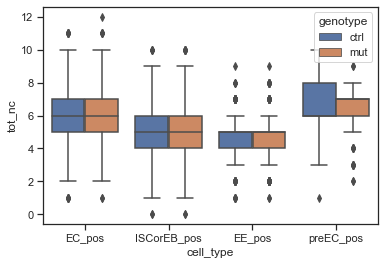

In [ ]:
import seaborn as sns

sns.boxplot(x='cell_type', y='tot_nc', hue='genotype', data=nc_df.reset_index().query('GFP_clone == 0'))

In [ ]:
nc_df

tot_nc  ECpos_nc  EEpos_nc  preECpos_nc  \
int_img label GFP_clone                                            
a1g01p1 11    0               4         3         0            0   
        12    0               4         3         0            0   
        15    0               2         0         0            0   
        17    2               2         2         0            0   
        18    0               2         1         0            0   
...                         ...       ...       ...          ...   
a2g13p3 280   0               3         2         0            0   
        281   0               3         2         0            0   
        283   0               5         2         0            0   
        285   0               3         1         0            0   
        286   0               3         1         0            0   

                         ISCorEBpos_nc    cell_type genotype  
int_img label GFP_clone                                       
a1g01p1 11    0                      1       EC_pos     ctrl  
        12    0                      1       EC_pos     ctrl  
        15    0                      2  ISCorEB_pos     ctrl  
        17    2                      0  ISCorEB_pos     ctrl  
        18    0                      1  ISCorEB_pos     ctrl  
...                                ...          ...      ...  
a2g13p3 280   0                      1  ISCorEB_pos      mut  
        281   0                      1  ISCorEB_pos      mut  
        283   0                      3       EC_pos      mut  
        285   0                      2       EC_pos      mut  
        286   0                      2  ISCorEB_pos      mut  

[18467 rows x 7 columns]